In [71]:
import random
import numpy as np
import matplotlib.pyplot as plt    
import scipy.stats as stats

In [72]:
def generate_distribution_P(A_len=4, B_len=4):
    uniform = [0] + sorted([random.random() for _ in range(A_len * B_len - 1)]) + [1]
    return np.array([uniform[i] - uniform[i-1] for i in range(1, len(uniform))]).reshape((A_len, B_len)) 

def build_interval_upper_borders(dist):
    """If dist == [0.2, 0.5, 0.3] -> return [0.2, 0.7, 1.0]"""
    out = [0] * len(dist)
    prev = 0
    for i, item in enumerate(dist):
        out[i] = item + prev
        prev += item
    return np.array(out)

def get_interval_index(interval_upper_borders, universal_x):
    """If interval_borders == [0.2, 0.7, 1.0] and universal_x == 0.4 -> return 1"""
    for i, item in enumerate(interval_upper_borders):
        if universal_x < item:
            return i    
    
def main(A, B, P, n, y=0.99):
    assert n > 40
    A = np.array(A)
    B = np.array(B)
    
    A_probs = P.sum(axis=1)
    B_probs = P.sum(axis=0)
    A_intervals = build_interval_upper_borders(A_probs)
    B_A_probs = P / A_probs.reshape(-1, 1)
    B_A_intervals = [build_interval_upper_borders(B_A_probs[i]) for i in range(len(A))]
    
    # generate n vectors
    vectors = [0] * n
    for i in range(n):
        a_idx = get_interval_index(A_intervals, np.random.uniform())
        b_idx = get_interval_index(B_A_intervals[a_idx], np.random.uniform())
        vectors[i] = (a_idx, b_idx)

    # build empirical matrix
    P_empirical = np.zeros_like(P)
    for (a_idx, b_idx) in vectors:
        P_empirical[a_idx, b_idx] += 1
    P_empirical /= n
    print(f"Теоретическая матрица вероятностей\n{P}\n\nЭмпирическая\n{P_empirical}\n")
    
    # calc correlation
    data = np.array([(A[a_idx], B[b_idx]) for (a_idx, b_idx) in vectors])
    A_data, B_data = data[:, 0], data[:, 1]
    A_empirical_mean = A_data.sum() / n
    B_empirical_mean = B_data.sum() / n
    A_empirical_disp = sum((a - A_empirical_mean) ** 2 for a in A_data) / (n-1)
    B_empirical_disp = sum((b - B_empirical_mean) ** 2 for b in B_data) / (n-1)
    empirical_corr = sum((a-A_empirical_mean)*(b-B_empirical_mean) 
                         for (a, b) in data)/(n-1)/(A_empirical_disp*B_empirical_disp) ** 0.5
    print(f"Эмпирические параметры:\nA  среднее       = {A_empirical_mean:<15}\n   дисперсия = {A_empirical_disp:<15}")
    print(f"B  среднее       = {B_empirical_mean:<15}\n   дисперсия = {B_empirical_disp:<15}")
    print(f"корреляция = {empirical_corr}\n")
    
    A_theory_mean = np.sum(A * A_probs)
    B_theory_mean = np.sum(B * B_probs)
    A_theory_disp = np.sum(A ** 2 * A_probs) - A_theory_mean ** 2
    B_theory_disp = np.sum(B ** 2 * B_probs) - B_theory_mean ** 2
    theory_corr = sum((A[i] - A_theory_mean)*(B[j] - B_theory_mean) * P[i, j] for i in range(len(A)) for j in range(len(B)))/(A_theory_disp*B_theory_disp) ** 0.5
    print(f"Теоретические параметры:\nA  среднее       = {A_theory_mean:<15}\n   дисперсия = {A_theory_disp:<15}")
    print(f"B  среднее       = {B_theory_mean:<15}\n   дисперсия = {B_theory_disp:<15}")
    print(f"корреляция = {theory_corr}\n")
    
    # intervals & hypothesis
    # means 
    print(f'Доверительные интервалы при y={y*100}%')
    A_mean_left, A_mean_right = stats.norm.interval(alpha=y, loc=A_empirical_mean, scale=(A_empirical_disp / n) ** 0.5)
    B_mean_left, B_mean_right = stats.norm.interval(alpha=y, loc=B_empirical_mean, scale=(B_empirical_disp / n) ** 0.5)
    
    # dispersions
    A_disp_left, A_disp_right = ((n - 1) * A_empirical_disp / stats.chi2.ppf(y + (1 - y) / 2, df=n-1),
                                  (n - 1) * A_empirical_disp / stats.chi2.ppf((1 - y) / 2, df=n-1))
    B_disp_left, B_disp_right = ((n - 1) * B_empirical_disp / stats.chi2.ppf(y + (1 - y) / 2, df=n-1),
                              (n - 1) * B_empirical_disp / stats.chi2.ppf((1 - y) / 2, df=n-1))
    
    print(f'\nДоверительные интервалы A:')
    in_interval = '' if A_mean_left <= A_theory_mean <= A_mean_right else 'не '
    print(f"мат. ожидание {in_interval}попадает в интервал: ({A_mean_left}, {A_mean_right})")
    
    in_interval = '' if A_disp_left <= A_theory_disp <= A_disp_right else 'не '
    print(f"дисперсия {in_interval}попадает в интервал: ({A_disp_left}, {A_disp_right})")
    
    print(f'\nДоверительные интервалы B:')
    in_interval = '' if B_mean_left <= B_theory_mean <= B_mean_right else 'не '
    print(f"мат. ожидание {in_interval}попадает в интервал: ({B_mean_left}, {B_mean_right})")
    
    in_interval = '' if B_disp_left <= B_theory_disp <= B_disp_right else 'не '
    print(f"дисперсия {in_interval}попадает в интервал: ({B_disp_left}, {B_disp_right})")
    
    # критерий колмогорова(гипотеза)
    # сначала найдём функции распределения
    F = np.zeros_like(P)
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            F[i, j] = P[:i+1, :j+1].sum()
    
    E = np.zeros_like(P)
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            E[i, j] = P_empirical[:i+1, :j+1].sum()
    print(f"\nФункция распределения F(a, b) = P(A <= a, B <= b)\n{F}\nЕмпирическая\n{E}\n")
    
    # проверяем сам критерий
    D = n ** 0.5 * max(abs(E[i, j] - F[i, j]) for i in range(len(A)) for j in range(len(B)))
    value_critical = 1.63
    print(f'Критерий Колмогорова.\nДля 0,01 p  уровня значимости допустимое значение D*sqrt(n) = {value_critical}')
    print(f'Проверяем гипотезу H0 (Эмпирические данные соответствуют распределению F). Получившееся D*sqrt(n) = {D}')
    print('Статистические данные не противоречат гипотезе H0' if D <= value_critical else
          'Следует отвергнуть гипотезу H0.')
    
    # histograms
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
    
    ax[0].set_title("A")
    ax[0].bar(A, (P_empirical * n).sum(axis=1))
    ax[0].plot(A, A_probs * n, color='red')
    ax[1].set_title("B")
    ax[1].bar(B, (P_empirical * n).sum(axis=0))
    ax[1].plot(B, B_probs * n, color='red')
    
    fig.show()

Теоретическая матрица вероятностей
[[0.00919813 0.06658618 0.18781476 0.00896231]
 [0.02546337 0.01749358 0.07061835 0.0659248 ]
 [0.00158595 0.30103962 0.00654151 0.06779601]
 [0.00985032 0.00815682 0.04089502 0.11207326]]

Эмпирическая
[[0.00946 0.06786 0.1831  0.00878]
 [0.02628 0.01762 0.0729  0.06446]
 [0.00176 0.30172 0.00706 0.06712]
 [0.01084 0.00812 0.04076 0.11216]]

Эмпирические параметры:
A  среднее       = 1.45222        
   дисперсия = 1.1298996695930306
B  среднее       = 1.76052        
   дисперсия = 0.7838650069000167
корреляция = 0.11996456723590097

Теоретические параметры:
A  среднее       = 1.4463525504494488
   дисперсия = 1.1341955612052534
B  среднее       = 1.7692846499395496
   дисперсия = 0.7791940867831131
корреляция = 0.11809217033222513

Доверительные интервалы при y=99.0%

Доверительные интервалы A:
мат. ожидание попадает в интервал: (1.4399751909142873, 1.4644648090857129)
дисперсия попадает в интервал: (1.1117052082568537, 1.1485241347734942)

Доверите

/home/work/.local/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


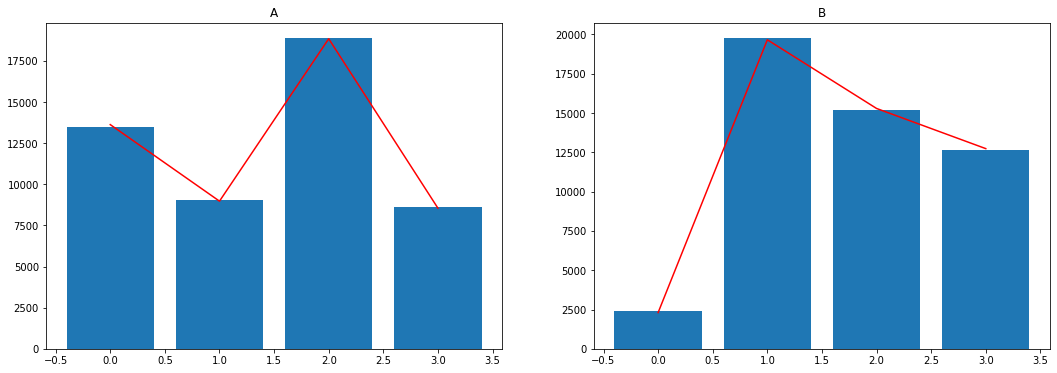

In [73]:
A = B = list(range(4))
P = generate_distribution_P(len(A), len(B))
main(A, B, P, 50000, y=0.99)